In [1]:
# Relational-GCN as implemented by M. Schlichtkrull, T. N. Kipf, 
# P. Bloem, R. van den Berg, I. Titov, M. Welling, 
# in Modeling Relational Data with Graph Convolutional Networks, 2017
import numpy as np
from multigraph import MultiGraph
import unicodecsv as csv

In [2]:
#import csv files of adjacency matrices
""" EXAMPLE
add,IS,operator
subtract,IS,operator
multiply,IS,operator
not,IS,logic
multliply,TAKES_N_ARGUMENTS,two
not,TAKES_N_ARGUMENTS,one
"""
op_graph = MultiGraph()
n = 45
#Load all CSV files
for i in range(n):
    print '.',
    with open('aifb_csv/aifb_relation_'+str(i)+'.csv', 'r') as csvfile:
        graphreader = csv.reader(csvfile, delimiter=",")
        for row in graphreader:
            op_graph.add_connection(row)
print('\n loaded '+str(op_graph.n_rels)+' relations.')

#Save the Multigraph object for the future
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

save_object(op_graph, 'adj_graph.pkl')
print("Saved graph object to disk")

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 loaded 45 relations.
Saved graph object to disk


In [3]:
import pickle
with open('adj_graph.pkl', 'rb') as inobj:
    op_graph = pickle.load(inobj)

In [4]:
num_nodes = op_graph.n_nodes
num_relations = op_graph.n_rels
print('number of nodes: {}'.format(num_nodes))
print('number of relations: {}'.format(num_relations))

number of nodes: 8284
number of relations: 45


In [6]:
import scipy.sparse as sp
# Create list of adjacency matrices, transpose, and identity
# This will be the input to the R-GCN
A = list()
for i in range(num_relations):
    k = op_graph.get_relation_label(i)
    A.append(op_graph.get_adjacency_matrix_k(k))
    A.append(op_graph.get_transpose_adjacency_matrix_k(k))
A.append(sp.identity(num_nodes).tocsr())
support = len(A)

# Normalize adjacency matrices
for i in range(len(A)):
    d = np.array(A[i].sum(1)).flatten()
    d_inv = 1. / d
    d_inv[np.isinf(d_inv)] = 0.
    D_inv = sp.diags(d_inv)
    A[i] = D_inv.dot(A[i]).tocsr()

# There is no feature matrix X, but the Convolution Layer expects one
# It will be ignored though (input is ignored with featureless=True)
X = sp.csr_matrix(A[0].shape)

/usr/local/anaconda3/envs/embeddings/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app


In [7]:
import random
from collections import defaultdict

# Get the y targets for training and testing. 
# We are training on the affiliations of the people in the organization. 
# There are 176 people and 4 affiliations.

def get_train_test_labels(graph, filename, train_frac=0.8):
    training_dict = defaultdict(list)
    train_ids = list()
    test_ids = list()
    with open(filename, 'r') as csvfile:
        graphreader = csv.reader(csvfile)
        i = 0 #first row is the header, skip it
        for row in graphreader:
            if i == 0:
                i += 1
                continue
            #replace name of node with node index in the graph
            idx = graph.nodes[row[0]]
            training_dict[row[1]].append(idx)
            #randomly sort sample into the training or test set
            if random.random() < train_frac:
                train_ids.append(idx)
            else:
                test_ids.append(idx)
    num_labels = len(training_dict.keys())
    #create a sparse matrix with all the nodes that have labels
    labels = sp.lil_matrix((num_nodes, num_labels))
    i = 0
    for k,v in training_dict.iteritems():   
        for s in v:
            labels[s, i] = 1
        i += 1
    return (labels, train_ids, test_ids)   

In [8]:
from rgcn.utils import *
#get train, validation, and testing sets
VALIDATION = True

y, train_idx, test_idx = get_train_test_labels(op_graph, 'aifb_csv/completeDataset.csv', train_frac=0.8)
y_train, y_val, y_test, idx_train, idx_val, idx_test = get_splits(y, train_idx, test_idx,VALIDATION)

train_mask = sample_mask(idx_train, y.shape[0])

In [10]:
#Now we define the R-GCN model! 

import keras
from keras.layers import Input, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2

from rgcn.layers.graph import GraphConvolution # Updated for Keras2
from rgcn.layers.input_adj import InputAdj #Updated for Keras2

encoding_dim = 16
L2 = 0.0
LR = 0.01
DO = 0.0


A_in = [InputAdj(sparse=True) for _ in range(support)]
X_in = Input(shape=(X.shape[1],), sparse=True)

# Define model architecture
ConvLayer1 = GraphConvolution(encoding_dim, support=support, num_bases=-1, use_bias=False, featureless=True, activation='relu', kernel_regularizer=l2(L2))
DropOutLayer = Dropout(DO)
ConvLayer2 = GraphConvolution(y_train.shape[1], support=support, use_bias=False, featureless=False, num_bases=-1, activation='softmax')

the_code = ConvLayer1([X_in] + A_in)
H = DropOutLayer(the_code)
Y = ConvLayer2([H] + A_in)

# Compile model
model = Model(inputs=[X_in] + A_in, outputs=Y)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=LR))
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_184 (InputLayer)          (None, 8284)         0                                            
__________________________________________________________________________________________________
input_93 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
input_94 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
input_95 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
input_96 (

In [11]:
print(ConvLayer1.get_config())
print(ConvLayer2.get_config())

{'kernel_initializer': 'glorot_uniform', 'name': 'graph_convolution_3', 'bias_regularizer': None, 'output_dim': 16, 'trainable': True, 'kernel_regularizer': {'l2': 0.0, 'l1': 0.0}, 'input_dim': 8284, 'num_bases': -1, 'use_bias': False, 'activation': 'relu'}
{'kernel_initializer': 'glorot_uniform', 'name': 'graph_convolution_4', 'bias_regularizer': None, 'output_dim': 4, 'trainable': True, 'kernel_regularizer': None, 'input_dim': 16, 'num_bases': -1, 'use_bias': False, 'activation': 'softmax'}


In [12]:
# Train the R-GCN. Need to feed all nodes at the same time, so set batch_size=num_nodes.
# Necessary that Inputs have sparse=True. batch_size would have size of many GB otherwise
import time
preds = None
NB_EPOCH = 50

for ep in range(1, NB_EPOCH + 1):
    t = time.time()
    # Single training iteration
    model.fit([X] + A, y=y_train, batch_size=num_nodes, sample_weight=train_mask, epochs=1, shuffle=False, verbose=0)
    if ep % 1 == 0:
        # Predict on full dataset
        preds = model.predict([X] + A, batch_size=num_nodes)
        # Train / validation scores
        train_val_loss, train_val_acc = evaluate_preds(preds, [y_train, y_val], [idx_train, idx_val])
        print("Epoch: {:04d}".format(ep),
              "train_loss= {:.4f}".format(train_val_loss[0]),
              "train_acc= {:.4f}".format(train_val_acc[0]),
              "val_loss= {:.4f}".format(train_val_loss[1]),
              "val_acc= {:.4f}".format(train_val_acc[1]),
              "time= {:.4f}".format(time.time() - t))

    else:
        print("Epoch: {:04d}".format(ep),
              "time= {:.4f}".format(time.time() - t))

('Epoch: 0001', 'train_loss= 1.3267', 'train_acc= 0.8684', 'val_loss= 1.3493', 'val_acc= 0.8571', 'time= 6.1729')
('Epoch: 0002', 'train_loss= 1.2164', 'train_acc= 0.9298', 'val_loss= 1.2779', 'val_acc= 0.8929', 'time= 1.0127')
('Epoch: 0003', 'train_loss= 1.0647', 'train_acc= 0.9298', 'val_loss= 1.1734', 'val_acc= 0.9286', 'time= 0.9268')
('Epoch: 0004', 'train_loss= 0.8990', 'train_acc= 0.9298', 'val_loss= 1.0496', 'val_acc= 0.9286', 'time= 0.9702')
('Epoch: 0005', 'train_loss= 0.7220', 'train_acc= 0.9298', 'val_loss= 0.9004', 'val_acc= 0.9643', 'time= 0.9509')
('Epoch: 0006', 'train_loss= 0.5667', 'train_acc= 0.9474', 'val_loss= 0.7487', 'val_acc= 0.9643', 'time= 1.0120')
('Epoch: 0007', 'train_loss= 0.4415', 'train_acc= 0.9561', 'val_loss= 0.6082', 'val_acc= 0.9643', 'time= 1.0895')
('Epoch: 0008', 'train_loss= 0.3433', 'train_acc= 0.9561', 'val_loss= 0.4862', 'val_acc= 1.0000', 'time= 0.9195')
('Epoch: 0009', 'train_loss= 0.2670', 'train_acc= 0.9561', 'val_loss= 0.3848', 'val_acc=

In [13]:
# See how it did on the test set
test_loss, test_acc = evaluate_preds(preds, [y_test], [idx_test])
print("Test set results:",
      "loss= {:.4f}".format(test_loss[0]),
      "accuracy= {:.4f}".format(test_acc[0]))

('Test set results:', 'loss= 0.0592', 'accuracy= 1.0000')


In [14]:
#Look at the embedding vectors that the model produced

coding_model = Model(inputs=[X_in] + A_in, outputs=the_code)
embedding = coding_model.predict([X] + A, batch_size=num_nodes)

In [15]:
#save the embeddings in order to plot them later
# serialize weights to HDF5
coding_model.save("rgcn_model.h5")
# serialize model to JSON
model_json = coding_model.to_json()
with open("rgcn_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("rgcn_model_weights.h5")

print("Saved model to disk")

Saved model to disk


In [16]:
# Each node in the AIFB dataset is either a person, a project, a publication, a group, etc.
# Here we get a list of all of the nodes that have a certain label and put them in a dictionary
import re
publications = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Publikationen\/viewPublikationOWL\/id[0-9]*instance)>")
authors = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Personen\/viewPersonOWL\/id[0-9]*instance)>")
groups = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Forschungsgruppen\/viewForschungsgruppeOWL\/id[0-9]*instance)>")
projects = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Projekte\/viewProjektOWL\/id[0-9]*instance)>")
subjects = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Forschungsgebiete\/viewForschungsgebietOWL\/id[0-9]*instance)>")
organizations = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Kooperationen\/viewOrganizationOWL\/id[0-9]*instance)>")

regex_dict = {"publications":publications, "authors":authors, 
              "groups":groups, "projects": projects, "subjects": subjects,
              "organizations":organizations}

from collections import defaultdict
categories = defaultdict(set)

with open("aifb_csv/aifb_stripped.nt") as f:
    for line in f:
        for k,reg in regex_dict.iteritems():
            finds = reg.match(line)
            if finds != None:
                categories[k].add(finds.group(1))

for k,v in categories.iteritems():
    print(k,len(v))

('organizations', 28)
('subjects', 146)
('publications', 1232)
('groups', 5)
('authors', 237)
('projects', 78)


In [17]:
#get the embeddings for 100 instances from each category

import random

subset_embeddings = defaultdict(list)
label_enum = list(enumerate(categories.keys(),1))
label_dict = {j: i for i,j in label_enum}

for k,v in categories.iteritems():
    samples = random.sample(v, min(len(v), 100))
    for s in samples:
        #print(s,embedding[op_graph.nodes[s]])
        subset_embeddings[k].append(embedding[op_graph.nodes[s]])
print(label_enum)

[(1, 'organizations'), (2, 'subjects'), (3, 'publications'), (4, 'groups'), (5, 'authors'), (6, 'projects')]


In [18]:
# functions for plotting different projections of the embeddings down to 2 dimensions

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import gensim

#from https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229
def tsnescatterplot(vector_dict, labels):
    #flatten the dictionary into two lists
    vectors = []
    vector_labels = []
    for k,v in vector_dict.iteritems():
        i = [l[0] for l in labels if l[1] == k]
        for s in v:
            vectors.append(s)
            vector_labels.append(i[0])
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(vectors)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    # display scatter plot   
    cmap = plt.cm.rainbow
    norm = mcolors.Normalize(vmin=0, vmax=len(labels))
    plt.figure(figsize=(8,6),dpi=200)
    plt.scatter(x_coords, y_coords, alpha=0.85, c=[cmap(norm(i)) for i in vector_labels])
    #draw the legend
    patches = []
    for l in labels:
        if l[1] in vector_dict:
            patches.append(mpatches.Patch(color=cmap(norm(l[0])), label=l[1]))
    plt.legend(handles=patches)
    #scatterpoints=1, loc='lower left', ncol=3, fontsize=8

    #for label, x, y in zip(vector_labels, x_coords, y_coords):
    #    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()-5.5, x_coords.max()+5.5)
    plt.ylim(y_coords.min()-5.5, y_coords.max()+5.5)
    plt.show()

import umap

def umapscatterplot(vector_dict, labels):
    #flatten the dictionary into two lists
    vectors = []
    vector_labels = []
    for k,v in vector_dict.iteritems():
        i = [l[0] for l in labels if l[1] == k]
        for s in v:
            vectors.append(s)
            vector_labels.append(i[0])
    # find tsne coords for 2 dimensions
    umapper = umap.UMAP()
    np.set_printoptions(suppress=True)
    Y = umapper.fit_transform(vectors)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    # display scatter plot   
    cmap = plt.cm.rainbow
    norm = mcolors.Normalize(vmin=0, vmax=len(labels))
    plt.figure(figsize=(8,6),dpi=200)
    plt.scatter(x_coords, y_coords, alpha=0.85, c=[cmap(norm(i)) for i in vector_labels])
    #draw the legend
    patches = []
    for l in labels:
        if l[1] in vector_dict:
            patches.append(mpatches.Patch(color=cmap(norm(l[0])), label=l[1]))
    plt.legend(handles=patches)
    #scatterpoints=1, loc='lower left', ncol=3, fontsize=8

    #for label, x, y in zip(vector_labels, x_coords, y_coords):
    #    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()-5.5, x_coords.max()+5.5)
    plt.ylim(y_coords.min()-5.5, y_coords.max()+5.5)
    plt.show()
from sklearn.decomposition import PCA

def pcascatterplot(vector_dict, labels):
    #flatten the dictionary into two lists
    vectors = []
    vector_labels = []
    for k,v in vector_dict.iteritems():
        i = [l[0] for l in labels if l[1] == k]
        for s in v:
            vectors.append(s)
            vector_labels.append(i[0])
    # find tsne coords for 2 dimensions
    pca = PCA(n_components=2)
    np.set_printoptions(suppress=True)
    Y = pca.fit_transform(vectors)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    cmap = plt.cm.rainbow
    norm = mcolors.Normalize(vmin=0, vmax=len(labels))
    # display scatter plot
    plt.figure(figsize=(8,6),dpi=200)
    plt.scatter(x_coords, y_coords,alpha=0.5, c=[cmap(norm(i)) for i in vector_labels])
    
   #draw the legend
    patches = []
    for l in labels:
        if l[1] in vector_dict:
            patches.append(mpatches.Patch(color=cmap(norm(l[0])), label=l[1]))
    plt.legend(handles=patches)
    #scatterpoints=1, loc='lower left', ncol=3, fontsize=8
    
    #for label, x, y in zip(vector_labels, x_coords, y_coords):
    #    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()-5.5, x_coords.max()+5.5)
    plt.ylim(y_coords.min()-5.5, y_coords.max()+5.5)
    plt.show()

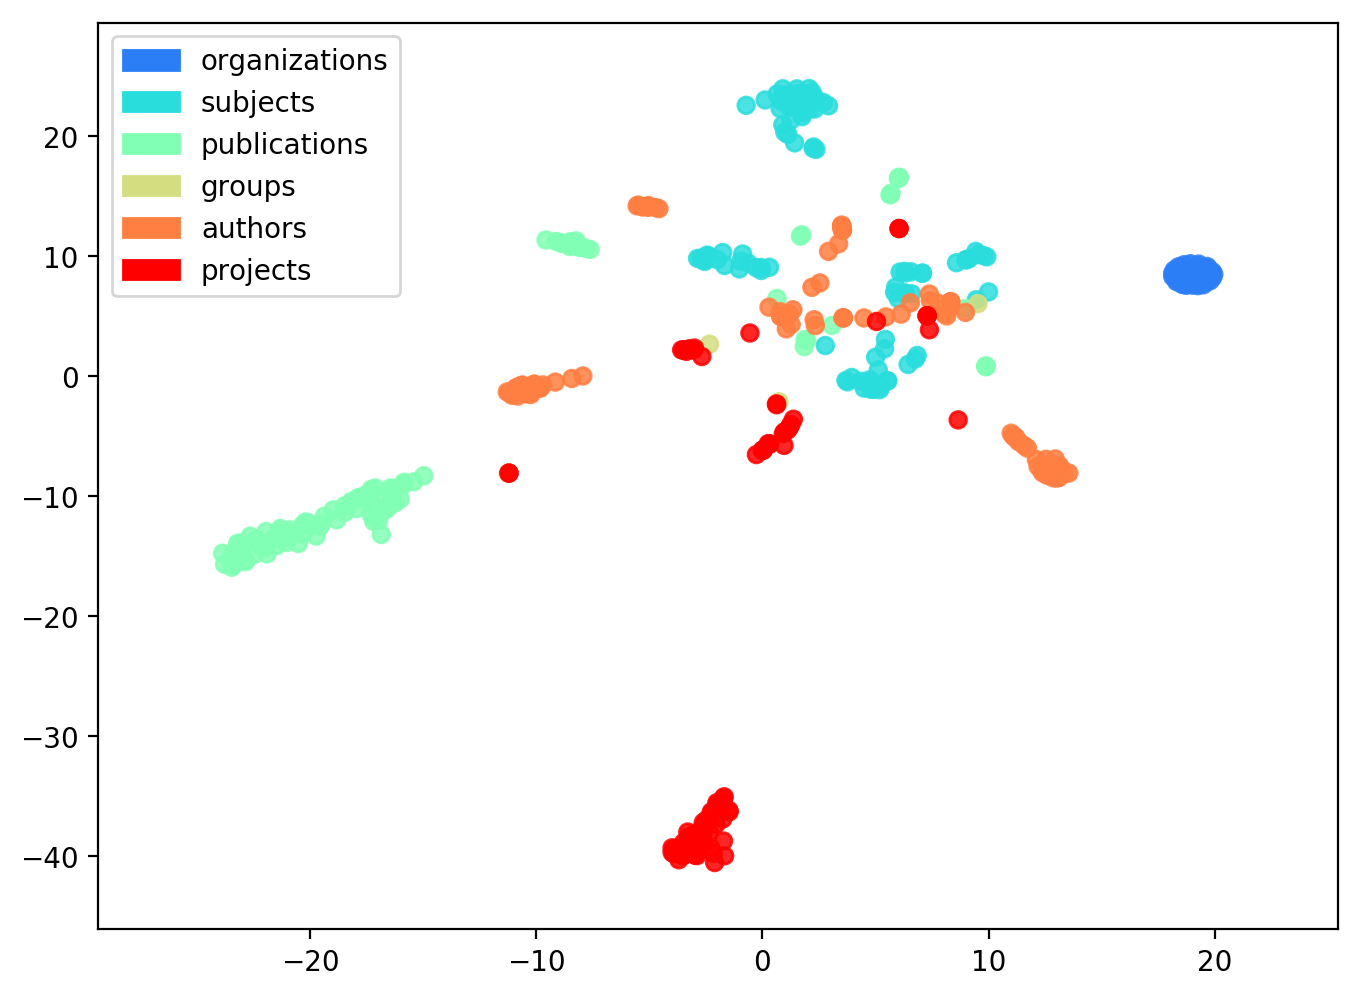

In [19]:
tsnescatterplot(subset_embeddings, label_enum)

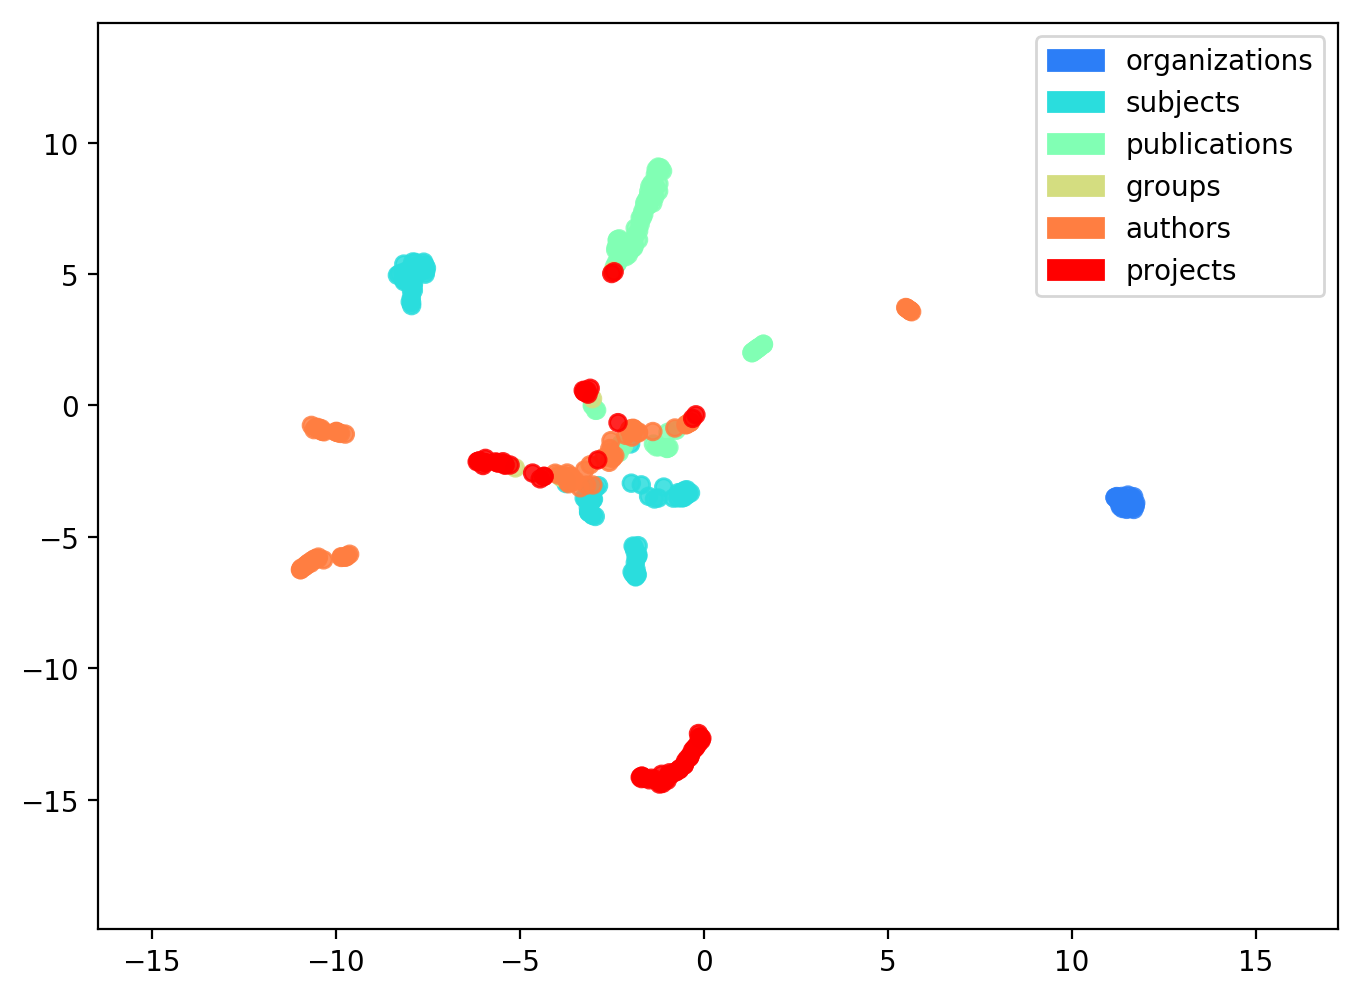

In [20]:
umapscatterplot(subset_embeddings, label_enum)

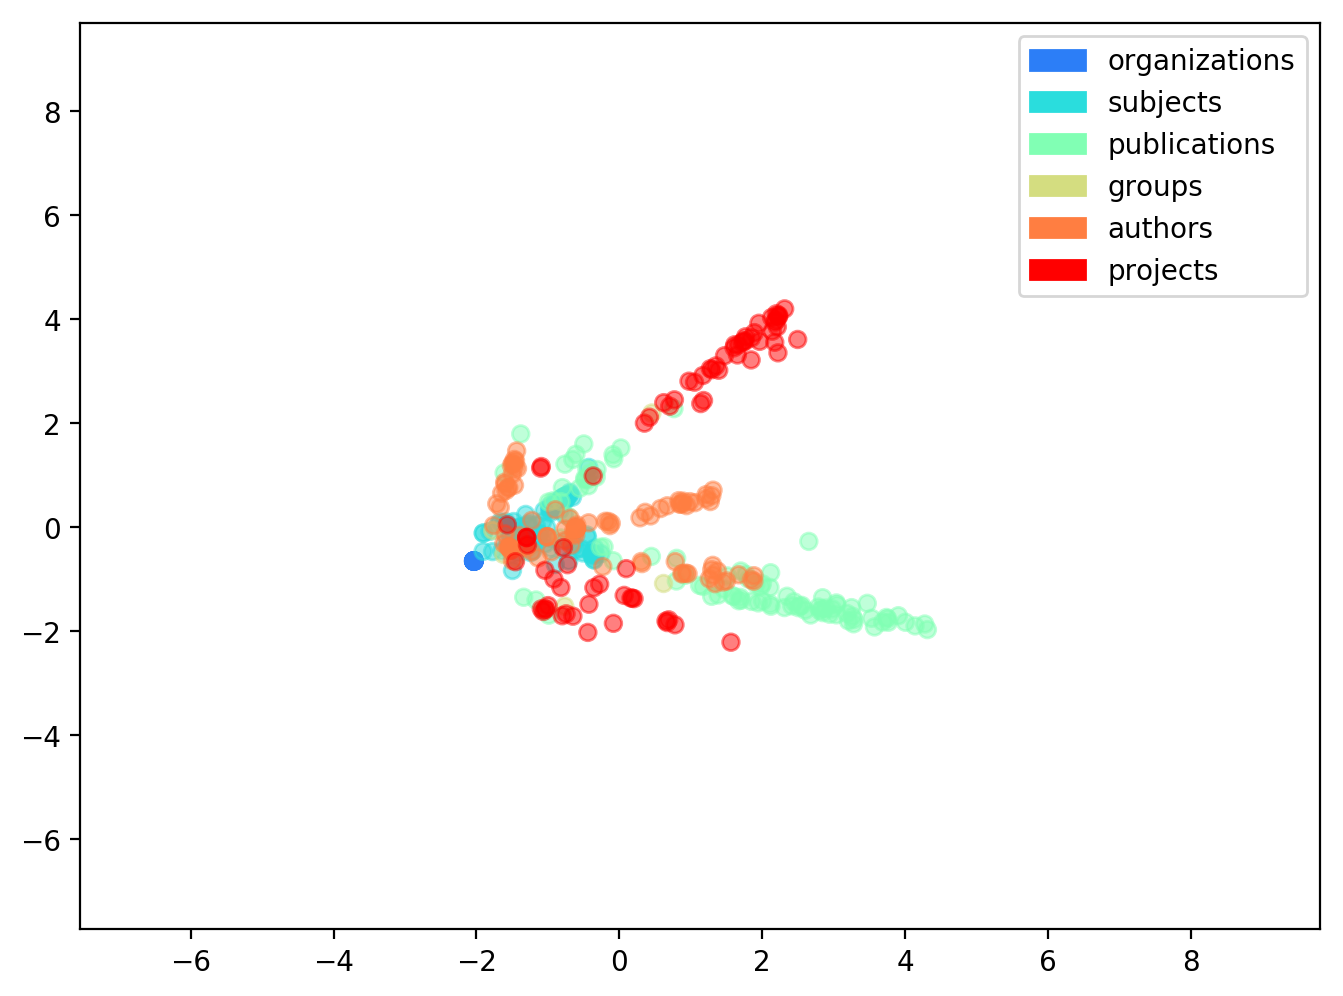

In [21]:
pcascatterplot(subset_embeddings, label_enum)

In [22]:
#let's look at scatter plots of classes and see how the embeddings look projected down to 2D

import unicodecsv as csv

def get_class_embeddings(full_embeddings, graph, filename):
    sub_dict = defaultdict(list)
    with open(filename, 'r') as csvfile:
        graphreader = csv.reader(csvfile)
        i = 0
        for row in graphreader:
            if i == 0:
                i += 1
                continue
            sub_dict[row[1].rsplit('/',2)[-1]].append(row[0])

    print("Number of instances in each label:")
    for k,v in sub_dict.iteritems():
        print(k,len(v))
    #get the embeddings for each of the classes in the sub_dict
    subset_embeddings = defaultdict(list)
    #subset_labels = []
    label_enum = list(enumerate(sub_dict.keys(),1))
    #label_dict = {j: i for i,j in label_enum}

    for k,v in sub_dict.iteritems():
        for s in v:
            subset_embeddings[k].append(full_embeddings[graph.nodes[s]])
            #subset_labels.append(label_dict[k])
    print("enumerating the labels:")
    print(label_enum)
    return (subset_embeddings, label_enum)

In [23]:
# The AIFB dataset has 176 people and they are associated with one of four affiliations in the organization.
# The completeSet.tsv file gives the URIs of the people and their affiliation
# (number, person, affiliation)

subset_embeddings, label_enum = get_class_embeddings(embedding,op_graph,'aifb_csv/completeDataset.csv')

Number of instances in each label:
(u'id4instance', 15)
(u'id3instance', 60)
(u'id2instance', 28)
(u'id1instance', 73)
enumerating the labels:
[(1, u'id4instance'), (2, u'id3instance'), (3, u'id2instance'), (4, u'id1instance')]


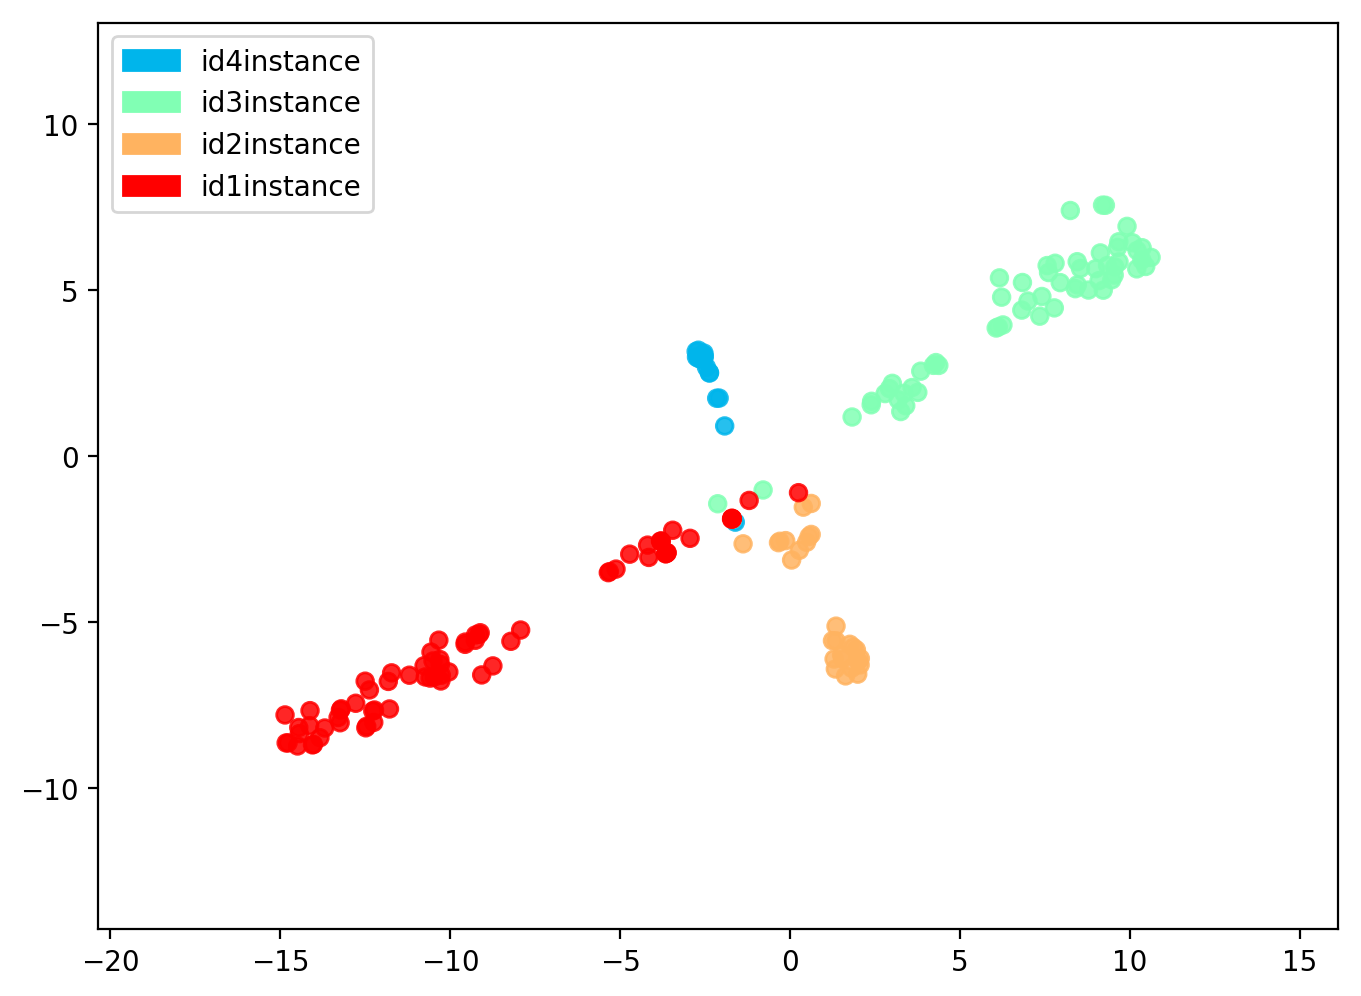

In [24]:
tsnescatterplot(subset_embeddings, label_enum)

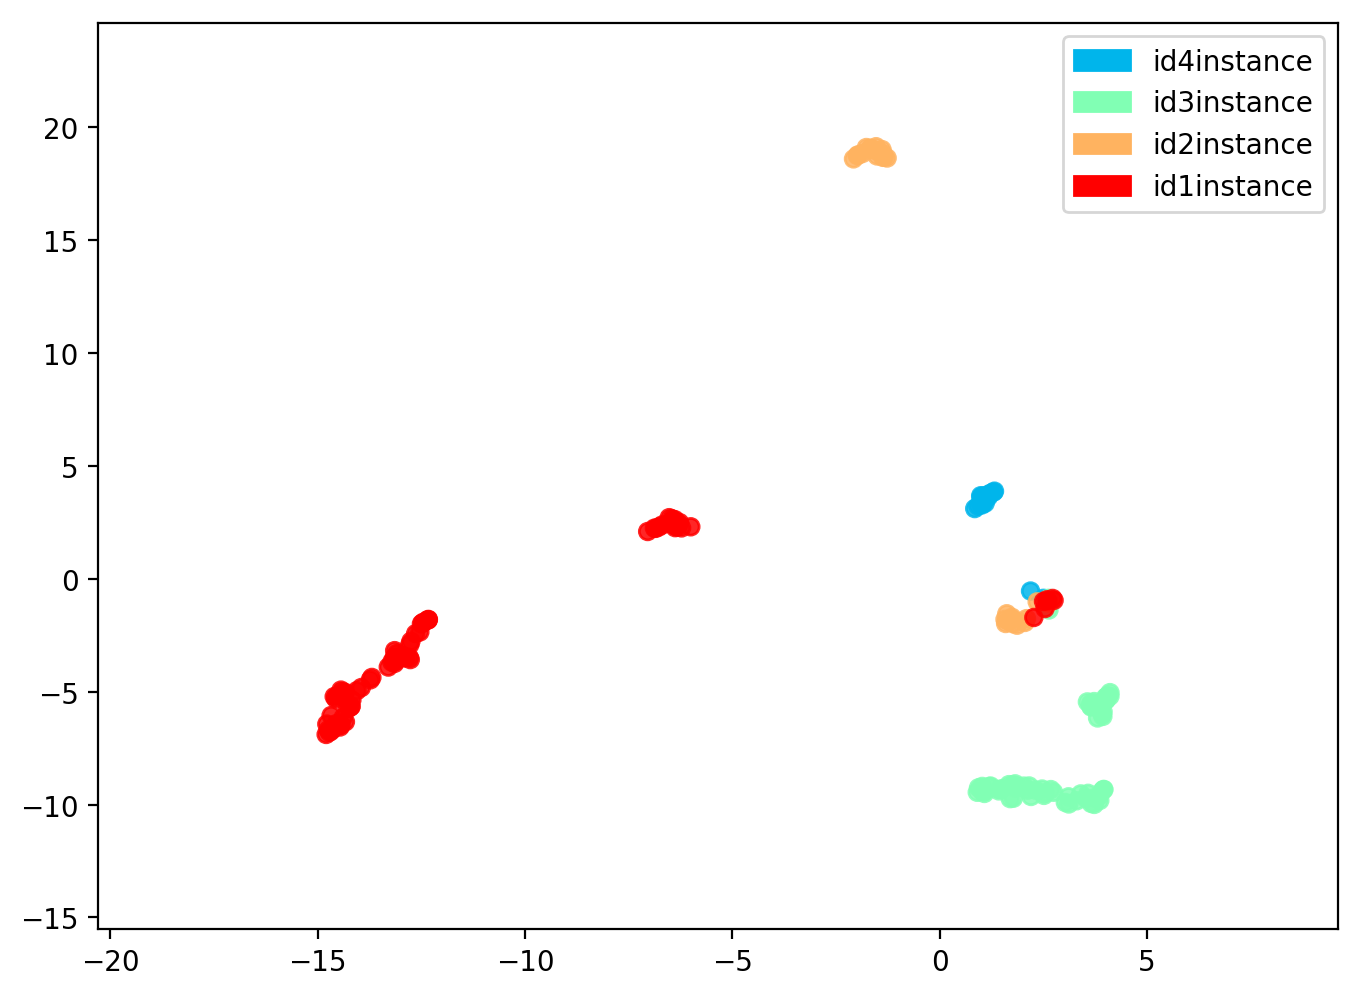

In [25]:
umapscatterplot(subset_embeddings, label_enum)

In [26]:
#Embeddings of the people who carried out certain projects
subset_embeddings, label_enum = get_class_embeddings(embedding,op_graph,'aifb_csv/project_carried_out.csv')

Number of instances in each label:
(u'id4instance', 5)
(u'id3instance', 43)
(u'id2instance', 18)
(u'id1instance', 12)
enumerating the labels:
[(1, u'id4instance'), (2, u'id3instance'), (3, u'id2instance'), (4, u'id1instance')]


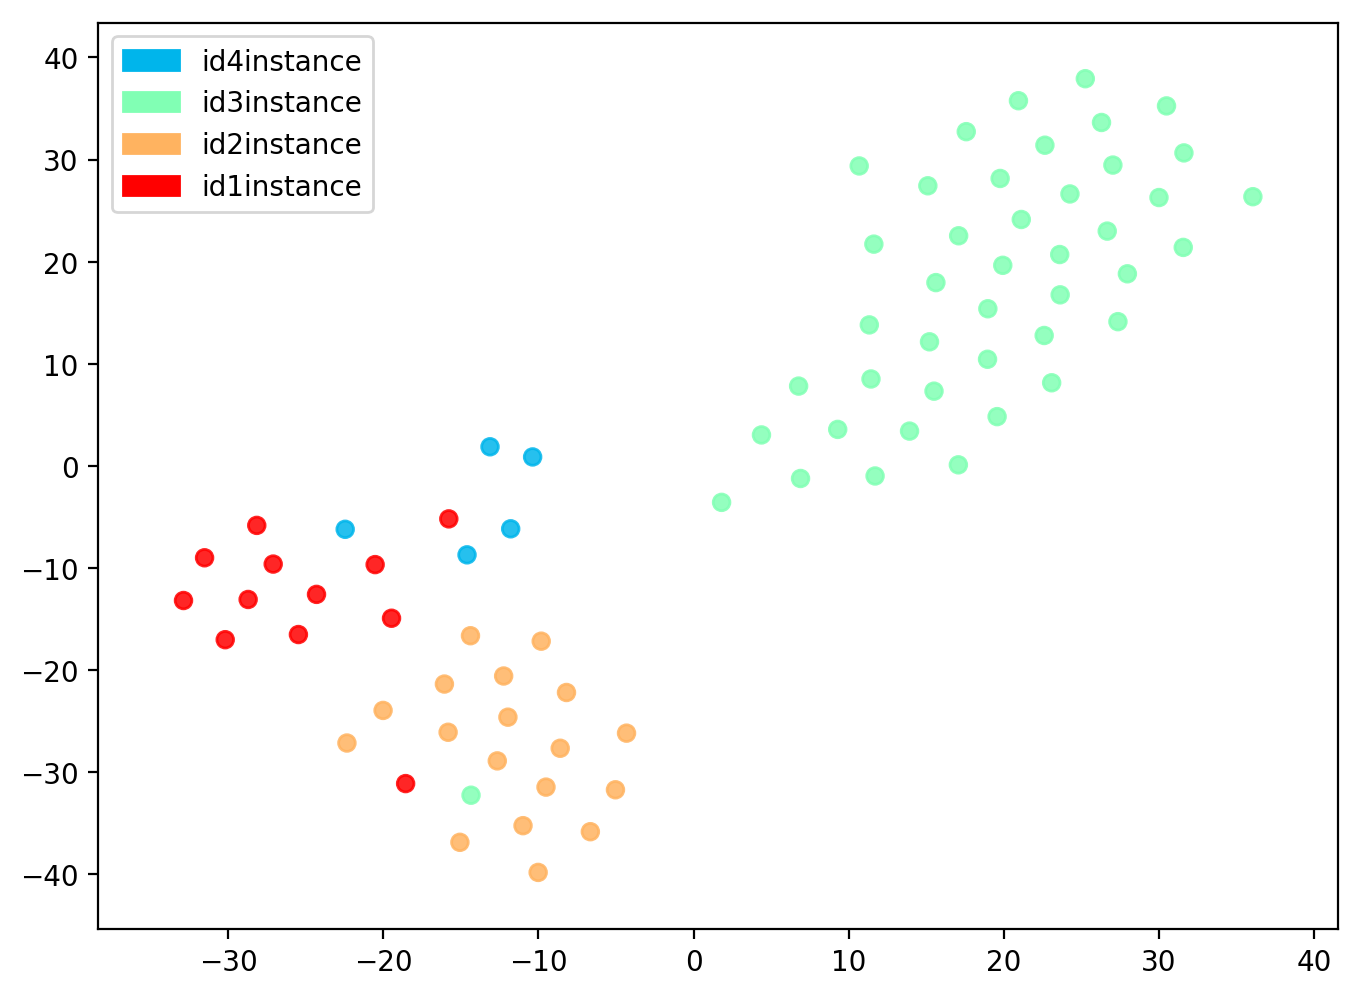

In [27]:
#Projections of the embeddings of the people who carried out certain projects using T-SNE
tsnescatterplot(subset_embeddings, label_enum)

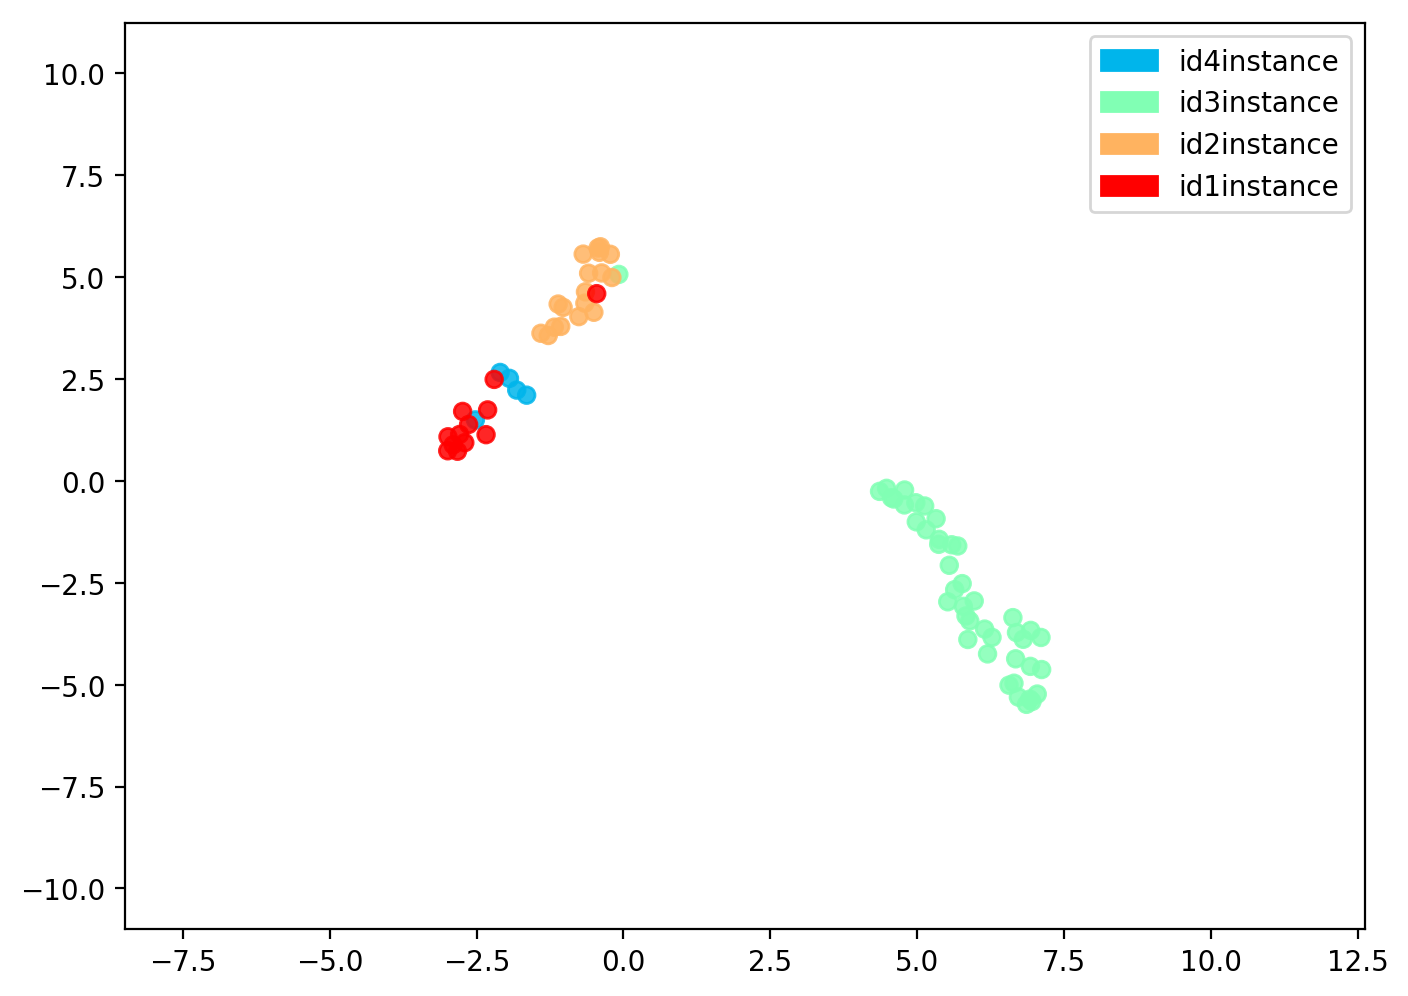

In [28]:
#Projections of the embeddings of the people who carried out certain projects using UMAP
umapscatterplot(subset_embeddings, label_enum)

In [29]:
#Embeddings of the projects and who they were financed by
finance_embeddings, finance_enum = get_class_embeddings(embedding,op_graph,'aifb_csv/projects_financed.csv')

Number of instances in each label:
(u'id19instance', 1)
(u'id4instance', 1)
(u'id31instance', 1)
(u'id26instance', 2)
(u'id10instance', 1)
(u'id16instance', 1)
(u'id23instance', 1)
(u'id25instance', 1)
(u'id1instance', 1)
(u'id32instance', 2)
(u'id20instance', 2)
(u'id6instance', 3)
(u'id24instance', 1)
(u'id2instance', 8)
(u'id7instance', 9)
(u'id5instance', 12)
(u'id27instance', 2)
(u'id3instance', 13)
(u'id13instance', 1)
(u'id17instance', 1)
enumerating the labels:
[(1, u'id19instance'), (2, u'id4instance'), (3, u'id31instance'), (4, u'id26instance'), (5, u'id10instance'), (6, u'id16instance'), (7, u'id23instance'), (8, u'id25instance'), (9, u'id1instance'), (10, u'id32instance'), (11, u'id20instance'), (12, u'id6instance'), (13, u'id24instance'), (14, u'id2instance'), (15, u'id7instance'), (16, u'id5instance'), (17, u'id27instance'), (18, u'id3instance'), (19, u'id13instance'), (20, u'id17instance')]


In [32]:
# Only use the financial sources that financed more than 3 projects
finance_embeddings = {k: v for k, v in finance_embeddings.iteritems() if len(v) > 3}
print("number of instances in each label:")
for k,v in finance_embeddings.iteritems():
    print (k,len(v))
finance_enum = list(enumerate(finance_embeddings.keys(),1))

number of instances in each label:
(u'id7instance', 9)
(u'id5instance', 12)
(u'id3instance', 13)
(u'id2instance', 8)


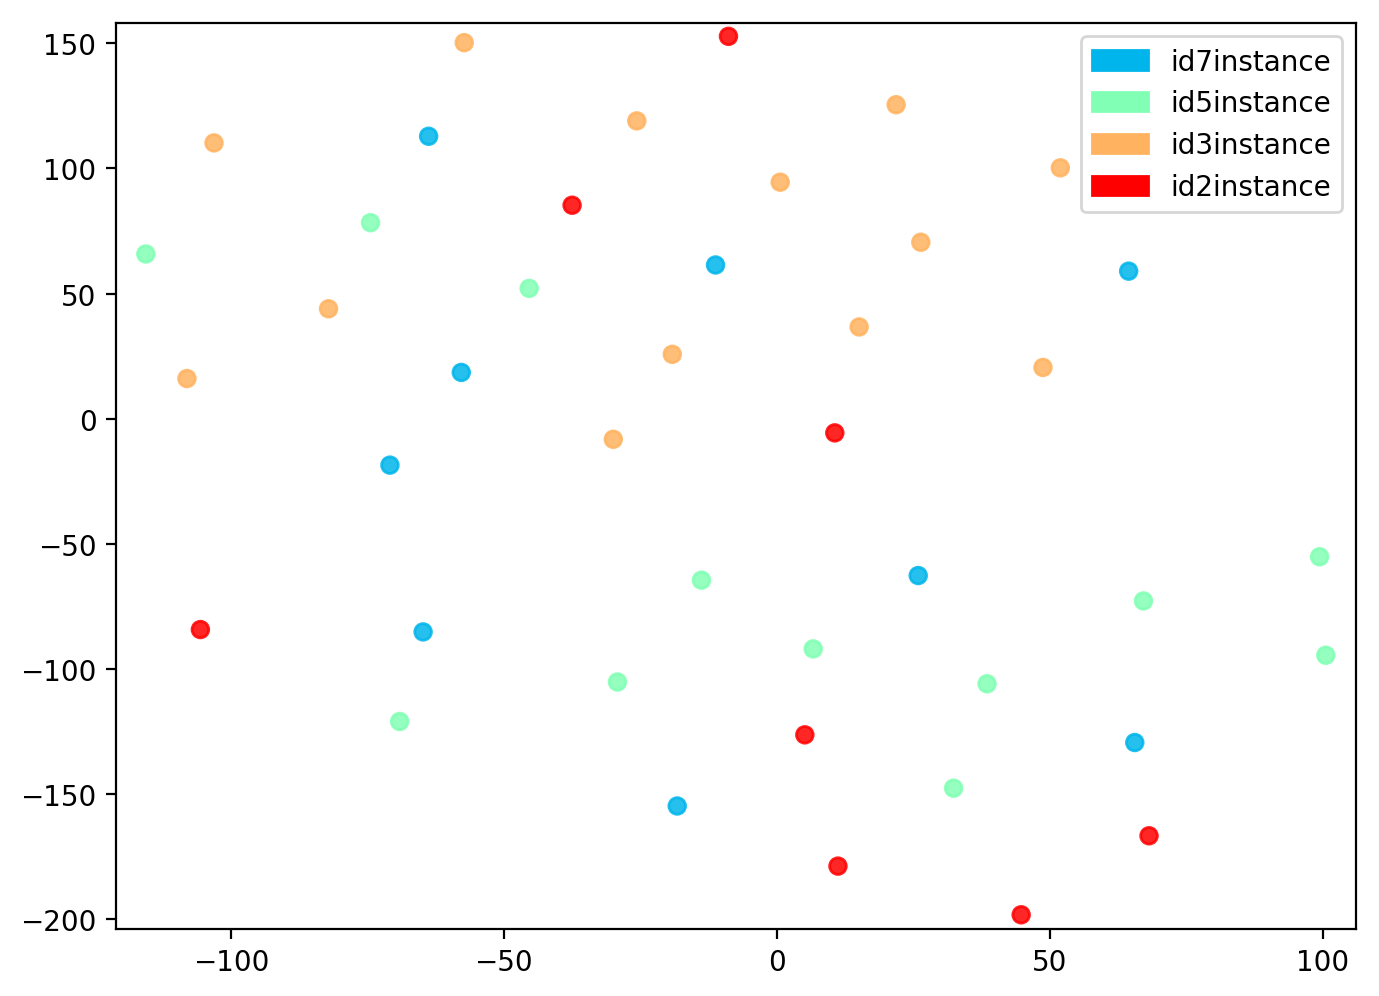

In [33]:
#Projections of the embeddings of the people who carried out certain projects using T-SNE
tsnescatterplot(finance_embeddings, finance_enum)

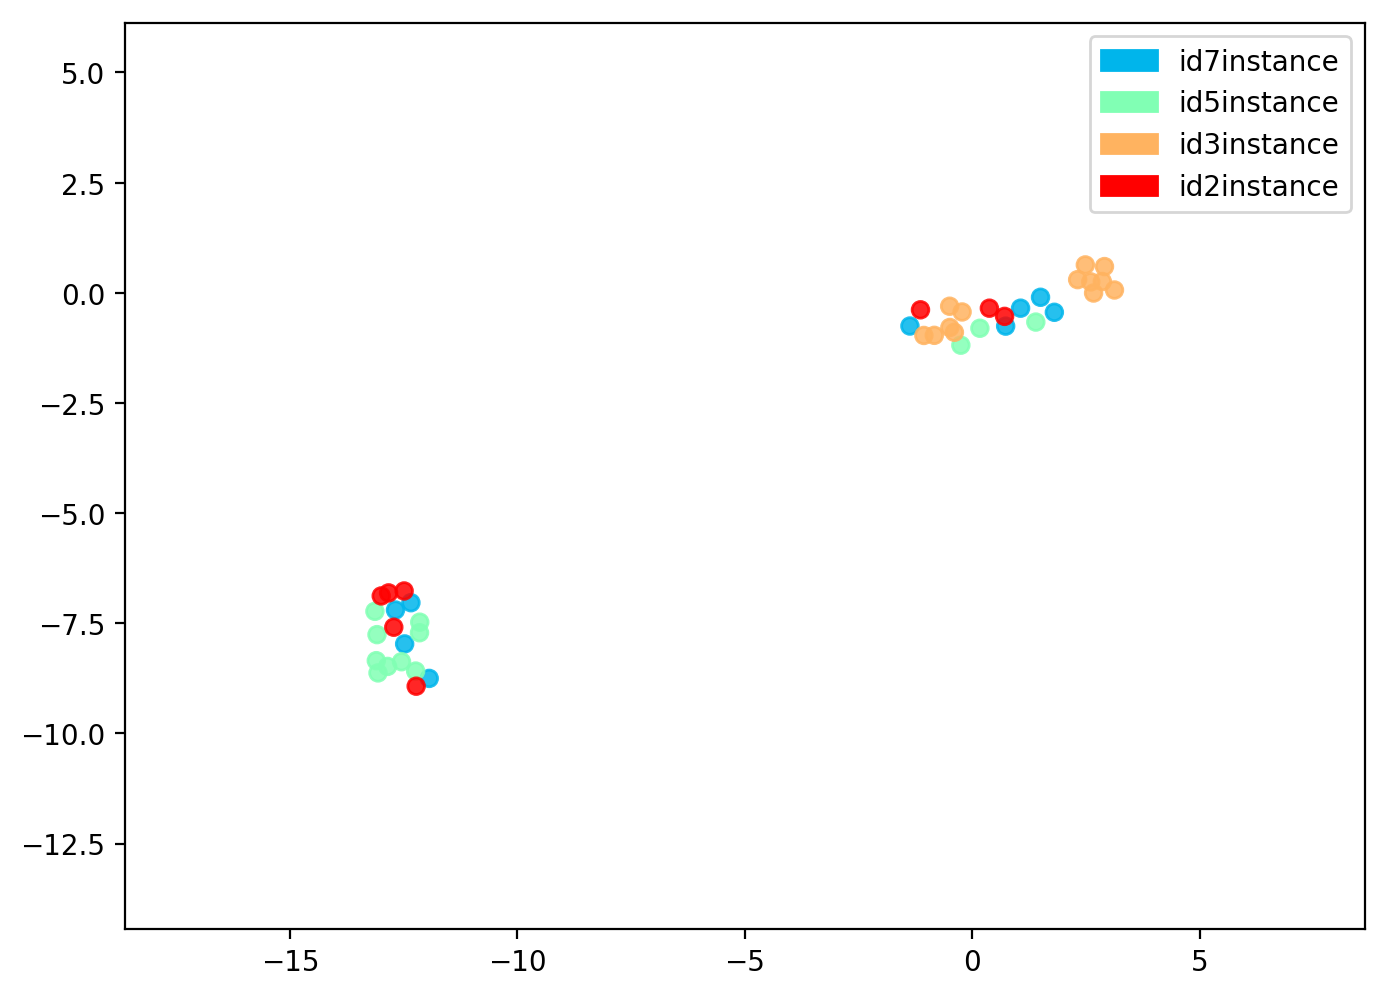

In [34]:
#Projections of the embeddings of the people who carried out certain projects using UMAP
umapscatterplot(finance_embeddings, finance_enum)